### **Linear Regression for house-price prediction**

In this notebook, we will build different regression models for california house price prediction: 

1. Linear Regression (with normal equation)

2. SGD Regression (linear regression with iterative optimization)

2. Polynomial Regression 

3. Regularized Regression models : RIDGE & LASSO

We will set regularization rate and polynomial degree with hyper-parameter tuning and cross validation. 

We will compare different models in terms of their parameter vectors and mean absolute error on train, eval and test sets.


#### *Imports* 

* For regression problems, we need to import classes and utilities from `sklearn.linear_model`.

* This module has implementation for different regression models like, LinearRegression, SGDRegressor, Ridge, Lasso, RidgeCV and LassoCV.

* We also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.

* The data preprocessing utilities are imported from `sklearn.preprocessing` modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings('ignore')

#### **Common set up**

Set up random seed to a number of your choice.

In [2]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples. 

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#### **Data Loading and Splitting**

We use california housing dataset for this demo. 

* We will load this dataset with `fetch_california_housing` API as a dataframe.

* We will load the data and split it inot three parts- train, dev  and test. Train+Dev will be used for cross validation and test will be used for evaluating the trained models.

In [4]:
# Fetching dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test-split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

# train --> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42)


Throughout this notebook, we will have the following pattern for each estimator:

* We will be using `pipeline` for combining data preprocessing and modelling steps. `cross_validate` for training the model with `ShuffleSplit` cross validation and `neg_mean_absolute_error` as a scoring metric.

* Convert the scores to error and report mean absolute errors on the dev set.

### 1. **Linear Regression (with normal equation)**

Let's use normal equation method to train linear regression model.

We set up pipeline with two stages: 

* Feature scaling to scale the features and 

* Linear regression on the transformed feature matrix.

Throughout this notebook, we will have the following pattern for each estimator:

* We will be using `pipeline` for combining data preprocessing and modelling steps. `cross_validate` for training the model with `ShuffleSplit` cross validation and `neg_mean_absolute_error` as a scoring metric.

* Convert the scores to error and report mean absolute errors on the dev set.

In [5]:
lin_reg_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("lin_reg", LinearRegression())
])


lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

lin_reg_train_error = -1 * lin_reg_cv_results['train_score']
lin_reg_test_error = -1 * lin_reg_cv_results['test_score']


print(f"Mean absolute error of linear regression model on the train set:\n" f"{lin_reg_train_error.mean():.3f} +/- {lin_reg_train_error.std():.3f}")

print()
print(f"Mean absolute error of linear regression model on the test set:\n" f"{lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}")


Mean absolute error of linear regression model on the train set:
0.530 +/- 0.002

Mean absolute error of linear regression model on the test set:
0.527 +/- 0.008


Both the errors are close, but are not low. This points to underfitting. We can address it by adding more feature through polynomial regression.

### 2. **SGD Regression (iterative optimization)**

Let's use iterative optimization method to train linear regression model.

We set up pipeline with two stages:

* Feature scaling to scale features and 

* SGD regression on the transformed feature matrix 


In [6]:
sgd_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd_reg', SGDRegressor(max_iter=np.ceil(1e6/com_train_features.shape[0]),
                            early_stopping=True,
                            eta0=1e-4,
                            learning_rate='constant',
                            tol=1e-5,
                            validation_fraction=0.1,
                            n_iter_no_change=5,
                            average=10,
                            random_state=42))
])

sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,  # shufflesplit declared above
                                    scoring='neg_mean_absolute_error',
                                    return_train_score=True,
                                    return_estimator=True)

sgd_train_error = -1 * sgd_reg_cv_results['train_score']
sgd_test_error = -1 * sgd_reg_cv_results['test_score']

print(f"Mean absolute error of SGD regression model on the train set:\n" f"{sgd_train_error.mean():.3f} +/- {sgd_train_error.std():.3f}")

print(f"Mean absolute error of SGD regression model on the test set:\n" f"{sgd_test_error.mean():.3f} +/- {sgd_test_error.std():.3f}")

Mean absolute error of SGD regression model on the train set:
0.534 +/- 0.013
Mean absolute error of SGD regression model on the test set:
0.530 +/- 0.010


#### SGD Regression : Regularization & Hyper-parameter tuning

We can also perform regularization with SGD. `SGDRegressor` has many hyperparameters that require careful tuning to achieve the same performance as wtih `LinearRegression`.

In [7]:
poly_sgd_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('feature_scaling', StandardScaler()),
    ('sgd_reg', SGDRegressor(
        penalty='elasticnet',
        random_state=42
    ))])

poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring='neg_mean_absolute_error',
                                     return_train_score=True,
                                     return_estimator=True)

poly_sgd_train_error = -1 * poly_sgd_cv_results['train_score']
poly_sgd_test_error = -1 * poly_sgd_cv_results['test_score']


print(f"Mean absolute error of SGD regression model on the train set. \n {poly_sgd_train_error.mean():.3f} +/- {poly_sgd_train_error.std():.3f}")

print(f"Mean absolute error of SGD regression model on the test set. \n {poly_sgd_test_error.mean():.3f} +/- {poly_sgd_test_error.std():.3f}")


Mean absolute error of SGD regression model on the train set. 
 10824283052.546 +/- 4423288211.832
Mean absolute error of SGD regression model on the test set. 
 10946788540.250 +/- 5396536227.703


The error is too high.

* So now, lets search for the best set of parameters for polynomial + SGD pipeline with `RandomizedSearchCV`.

* In `RandomizedSearchCV`, we need to specify distributions for hyperparameters.

In [8]:
class uniform_int:
    """ 
    Integer valued version of the uniform distributions
    """

    def __init__(self, a, b):
        self._distribution = uniform(a, b)

    def rvs(self, *args, **kwargs):
        """ Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


Let's specify `RandomizedSearchCV` set up.

In [9]:
param_distributions = {
    'poly__degree':[1,2,3],
    'sgd_reg__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'sgd_reg__l1_ratio': uniform(0,1),
    'sgd_reg__eta0': loguniform(1e-5,1),
    'sgd_reg__power_t': uniform(0,1)
} 

poly_sgd_random_search_cv = RandomizedSearchCV(
    poly_sgd_pipeline, param_distributions=param_distributions, n_iter =10, cv=cv, verbose=1, scoring='neg_mean_absolute_error'
)

poly_sgd_random_search_cv.fit(com_train_features,com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000236BA2BA580>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000236B8ADA220>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'adaptive',
                                                                   'invscaling'],
                                        'sgd_reg__power_t': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000236B8ADA550>},
                   scoring='neg_mean_absolute_error', verbose=1)

The best score can be obtained as follows :

In [10]:
poly_sgd_random_search_cv.best_score_

-0.5271573234998475

The best set of parameters are obtained as follows:

In [11]:
poly_sgd_random_search_cv.best_params_

{'poly__degree': 2,
 'sgd_reg__eta0': 2.3063822138075523e-05,
 'sgd_reg__l1_ratio': 0.4590765695698895,
 'sgd_reg__learning_rate': 'adaptive',
 'sgd_reg__power_t': 0.17208702250773023}

And the best estimator can be accessed as follows : 

In [12]:
poly_sgd_random_search_cv.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('feature_scaling', StandardScaler()),
                ('sgd_reg',
                 SGDRegressor(eta0=2.3063822138075523e-05,
                              l1_ratio=0.4590765695698895,
                              learning_rate='adaptive', penalty='elasticnet',
                              power_t=0.17208702250773023, random_state=42))])

### 3. **Polynomial Regression**

* We will train a polynomial model with degree 2 and later we will use `validation_curve` to find out right degree to use for polynomial models.

* `PolynomialFeatures` transforms the features to the user specified degrees (here it is 2). 

* We perform feature scaling on the transformed features before using them for training the regression model.


In [13]:
poly_reg_pipeline = Pipeline([
                             ('poly', PolynomialFeatures(degree=2)),
                             ('feature_scaling', StandardScaler()),
                             ('lin_reg', LinearRegression())])

poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring='neg_mean_absolute_error',
                                     return_train_score=True,
                                     return_estimator=True)

poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1 * poly_reg_cv_results['test_score']

print(f"Mean absolute error of polynomial regression model of degree 2 on the train set: \n" f"{poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}")

print(f"Mean absolute error of polynomial regression model of degree 2 on the test set: \n" f"{poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}")


Mean absolute error of polynomial regression model of degree 2 on the train set: 
0.461 +/- 0.003
Mean absolute error of polynomial regression model of degree 2 on the test set: 
0.485 +/- 0.030


Notice that the training and validation errors have reduced after using the second order polynomial features to represent the model.

Instead of using all polynomial feature, we use only interaction feature terms (i.e `interaction_only = True` ) in polynomial model and train the linear regression model.

In [14]:
poly_reg_pipeline = Pipeline([
                             ('poly', PolynomialFeatures(
                                 degree=2, interaction_only=True)),
                             ('feature_scaling', StandardScaler()),
                             ('lin_reg', LinearRegression())])

poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring='neg_mean_absolute_error',
                                     return_train_score=True,
                                     return_estimator=True)

poly_reg_train_error = -1 * poly_reg_cv_results['train_score']
poly_reg_test_error = -1*poly_reg_cv_results['test_score']

print(f"Mean absolute error of polynomial regression model of degree 2 on the train set: \n" f"{poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}")

print(f"Mean absolute error of polynomial regression model of degree 2 on the test set: \n" f"{poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}")


Mean absolute error of polynomial regression model of degree 2 on the train set: 
0.478 +/- 0.003
Mean absolute error of polynomial regression model of degree 2 on the test set: 
0.497 +/- 0.024


Notice that the training and validation errors have increased after using `interaction_only = True` to represent the model.

Let's figure out which degree polynomial is better suited for the regression problem at our hand. For that we will use `validation_curve`, which can be considered as a manual huperparameter tuning.

Here we specify a list of values that we want to try for polynomial degree and specify it as a parameter in `validation_curve`. 

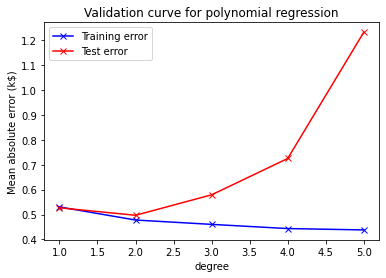

In [15]:
degree = [1, 2, 3, 4, 5]

train_scores, test_scores = validation_curve(
    poly_reg_pipeline, com_train_features, com_train_labels, param_name='poly__degree',
    param_range=degree, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2
)

train_errors, test_errors = -train_scores, -test_scores
plt.plot(degree, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(degree, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()

plt.xlabel("degree")
plt.ylabel("Mean absolute error (k$)")
plt.title("Validation curve for polynomial regression")
plt.show()

We would select a degree for which the mean absolute error is the least. 

In this case, it is degree = 2 that yields the least mean absolute error and that would be selected as an optimal degree for polynomial regression. 

### 4. **Ridge Regression**

* The polynomial models have a tendency to overfit - if we use higher order polynomial features. 

* We will use `Ridge` regression - which penalizes for excessive model complexity in the polynomial regression by adding a regularization term. 

* Here we specify the regularization rate `alpha` as 0.5 and train the regression model. 

* Later we will launch hyperparameter search for the right value of `alpha` such that it leads to the least cross validation errors.

In [16]:
ridge_reg_pipeline = Pipeline([
                             ('poly', PolynomialFeatures(degree=2)),
                             ('feature_scaling', StandardScaler()),
                             ('ridge', Ridge(alpha=0.5))])

ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring='neg_mean_absolute_error',
                                      return_train_score=True,
                                      return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

print(f'Mean absolute error of ridge regression model (alpha=0.5) the train set: \n' f'{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}')

print(f'Mean absolute error of ridge regression model (alpha=0.5) the test set: \n' f'{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}')


Mean absolute error of ridge regression model (alpha=0.5) the train set: 
0.481 +/- 0.003
Mean absolute error of ridge regression model (alpha=0.5) the test set: 
0.487 +/- 0.006


#### Hyperparameter tuning for ridge regularization rate

In [17]:
alpha_list = np.logspace(-4, 0, num=20)

ridge_reg_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaling', StandardScaler()),
    ('ridge_cv', RidgeCV(alphas=alpha_list, cv=cv, scoring='neg_mean_absolute_error'))
])

ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)

In [18]:
print('The score with the best alpha is :',
      f'{ridge_reg_cv_results[-1].best_score_:.3f}')

print('The error with the best alpha is :',
      f'{-ridge_reg_cv_results[-1].best_score_:.3f}')

print('The best value for alpha :', ridge_reg_cv_results[-1].alpha_)


The score with the best alpha is : -0.473
The error with the best alpha is : 0.473
The best value for alpha : 0.007847599703514606


#### Ridge HPT through **GridSearchCV**

In [19]:
ridge_grid_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaling', StandardScaler()),
    ('ridge', Ridge())])

param_grid = {'poly__degree': (1, 2, 3),
              'ridge__alpha': np.logspace(-4, 0, num=20)}

In [20]:
ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=-1,
                                 cv=cv,
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True)

ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

`ridge_grid_search.best_index_` gives the index of the best parameter in the list.


In [21]:
# best parameter
ridge_grid_search.cv_results_['params'][ridge_grid_search.best_index_]

{'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}

In [22]:
mean_train_error = -1 * ridge_grid_search.cv_results_[
        'mean_train_score'][ridge_grid_search.best_index_]

mean_test_error = -1 * ridge_grid_search.cv_results_[
        'mean_test_score'][ridge_grid_search.best_index_]

std_train_error = -1 * ridge_grid_search.cv_results_[
        'std_train_score'][ridge_grid_search.best_index_]

std_test_error = -1 * ridge_grid_search.cv_results_[
        'std_test_score'][ridge_grid_search.best_index_]


print(f'Best Mean absolute error of polynomial ridge regression model on the train set:\n' f"{mean_train_error:.3f} +/- {std_train_error:.3f}")

print()
print(f'Best Mean absolute error of polynomial ridge regression model on the test set:\n' f"{mean_test_error:.3f} +/- {std_test_error:.3f}")


Best Mean absolute error of polynomial ridge regression model on the train set:
0.463 +/- -0.004

Best Mean absolute error of polynomial ridge regression model on the test set:
0.474 +/- -0.015


In [23]:
print('Mean cross validated score of the best estimator is : ',
      ridge_grid_search.best_score_)
    
print('Mean cross validated error of the best estimator is : ', -
      ridge_grid_search.best_score_)


Mean cross validated score of the best estimator is :  -0.4738651177003218
Mean cross validated error of the best estimator is :  0.4738651177003218


In [24]:
ridge_grid_search.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('feature_scaling', StandardScaler()),
                ('ridge', Ridge(alpha=0.007847599703514606))])

### 5. **Lasso Regression**

In [25]:
lasso_reg_pipeline = Pipeline([
                                ('poly',PolynomialFeatures(degree=2)),
                                ('feature_scaling',StandardScaler()),
                                ('lasso',Lasso(alpha=0.001))
])

lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                       com_train_features,
                                       com_train_labels,
                                       scoring='neg_mean_absolute_error',
                                       return_train_score=True,
                                       return_estimator=True )

lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error =-1 * lasso_reg_cv_results['test_score']

print(f'Mean absolute error of linear regression model on the train set : \n' f'{lasso_reg_train_error.mean():.3f} +/- {lasso_reg_train_error.std():.3f}') 

print(f'Mean absolute error of linear regression model on the test set : \n' f'{lasso_reg_test_error.mean():.3f} +/- {lasso_reg_test_error.std():.3f}') 

Mean absolute error of linear regression model on the train set : 
0.503 +/- 0.008
Mean absolute error of linear regression model on the test set : 
0.512 +/- 0.015


#### Lasso Regression with **GridSearchCV**

In [26]:
lasso_grid_pipeline =Pipeline([ 
                             ('poly',PolynomialFeatures()),
                             ('feature_scaling',StandardScaler()),
                             ('lasso',Lasso())])

param_grid ={"poly__degree": (1,2,3),
             "lasso__alpha": np.logspace(-4,0, num=20)}

lasso_grid_search = GridSearchCV(lasso_grid_pipeline,
                                param_grid=param_grid,                         n_jobs=2,
                                cv =cv,
                                scoring='neg_mean_absolute_error',
                                return_train_score = True) 

lasso_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=2,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         'poly__degree': (1, 2, 3)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [27]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]

mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]

std_train_error = -1 * lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]

std_test_error = -1 * lasso_grid_search.cv_results_['std_test_score'][lasso_grid_search.best_index_]


print(f'Best Mean absolute error of polynomial lasso regression model on the train set : \n' f"{mean_train_error:.3f} +/- {std_train_error:.3f}")

print(f'Best Mean absolute error of polynomial lasso regression model on the test set : \n' f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial lasso regression model on the train set : 
0.462 +/- -0.003
Best Mean absolute error of polynomial lasso regression model on the test set : 
0.488 +/- -0.046


### **Comparision of weight vectors**

Let's look at the weight vectors produced by different models.

#### 1. Polynomial Regression with CV

In [28]:
feature_names = poly_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns)

print(feature_names)

['1' 'MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude' 'MedInc HouseAge' 'MedInc AveRooms'
 'MedInc AveBedrms' 'MedInc Population' 'MedInc AveOccup'
 'MedInc Latitude' 'MedInc Longitude' 'HouseAge AveRooms'
 'HouseAge AveBedrms' 'HouseAge Population' 'HouseAge AveOccup'
 'HouseAge Latitude' 'HouseAge Longitude' 'AveRooms AveBedrms'
 'AveRooms Population' 'AveRooms AveOccup' 'AveRooms Latitude'
 'AveRooms Longitude' 'AveBedrms Population' 'AveBedrms AveOccup'
 'AveBedrms Latitude' 'AveBedrms Longitude' 'Population AveOccup'
 'Population Latitude' 'Population Longitude' 'AveOccup Latitude'
 'AveOccup Longitude' 'Latitude Longitude']


In [29]:
print(poly_reg_cv_results['estimator'][0][-1])

LinearRegression()


In [30]:
coefs = [i[-1].coef_ for i in poly_reg_cv_results["estimator"]]
print(coefs[:2])

[array([-1.20413427e-12, -1.61569371e+01, -1.21092383e+01,  1.11235836e+01,
       -9.44654938e+00, -2.34941156e+00,  7.36635757e+01,  1.63563849e+00,
       -4.68455430e-01,  1.12528038e-01, -1.63804130e-01,  2.05049845e-01,
        2.99114714e-01,  1.98368002e+00, -8.06864364e+00, -2.47640735e+01,
       -2.20667537e-01,  3.51848996e-01,  5.66131647e-02, -1.71127167e+00,
       -5.42873233e+00, -1.75752779e+01, -4.24679503e-02, -3.52790487e-01,
       -1.84145609e-01,  6.71628693e+00,  1.72961794e+01,  5.20628084e-01,
        5.12438573e-01, -5.63236511e+00, -1.44389342e+01,  1.30559891e+00,
       -5.26771610e-01, -2.35921682e+00,  3.51078155e+01,  1.10727914e+02,
        2.02753888e+00]), array([-8.21282625e-14, -1.70030899e+01, -1.17430112e+01,  1.22404452e+01,
       -9.31590879e+00, -1.09418936e+00,  2.49354245e+00,  1.03838098e+00,
        4.18560276e-02,  9.80811903e-02, -1.17108267e-01,  1.96625060e-01,
        3.77107433e-01, -9.87223928e-01, -8.00160924e+00, -2.57487308e+01

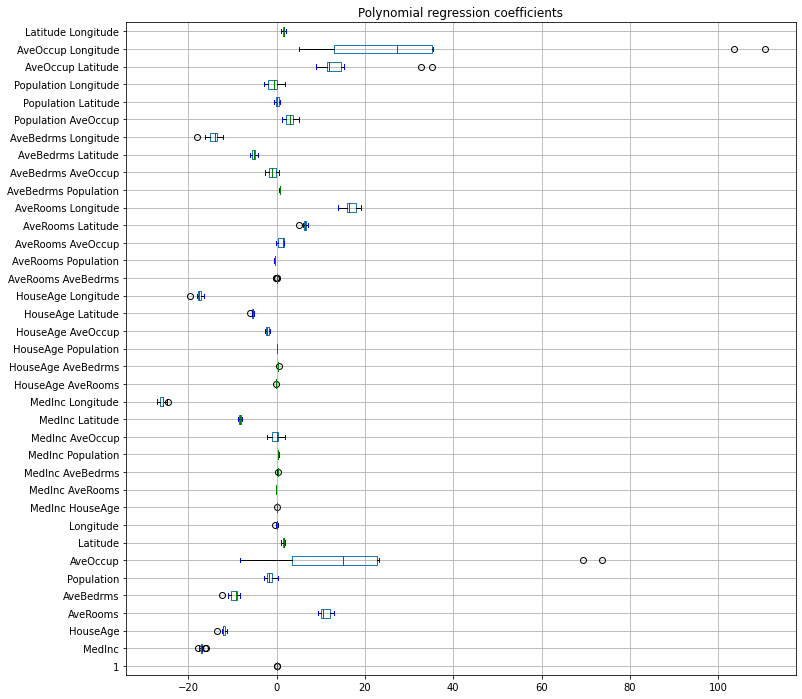

In [31]:
weights_poly_df = pd.DataFrame(coefs, columns=feature_names)

color = {'whiskers': 'black', 'medians': 'green', 'caps': 'blue'}
weights_poly_df.plot.box(color=color, vert=False, figsize=(12, 12))

plt.title('Polynomial regression coefficients')
plt.grid()
plt.show()

#### 2. Ridge Regression with CV

In [32]:
ridge_reg_pipeline = Pipeline([
                             ('poly', PolynomialFeatures(degree=2)),
                             ('feature_scaling', StandardScaler()),
                             ('ridge', Ridge(alpha=0.5))])

ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring='neg_mean_absolute_error',
                                      return_train_score=True,
                                      return_estimator=True)


In [33]:
feature_names = ridge_reg_cv_results['estimator'][0][0].get_feature_names_out(
    input_features=train_features.columns)

feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [34]:
coefs = [i[-1].coef_ for i in ridge_reg_cv_results["estimator"]]
print(coefs[:1])

[array([ 0.        , -2.28217749, -2.67967218, -0.58591007,  1.39039817,
       -0.25786929, -2.50666484,  0.34514535, -1.90285395, -0.55366407,
        0.30043979,  0.53858318, -0.34636673,  0.367585  ,  0.92303558,
       -2.5725778 , -5.77825751,  0.19560824, -0.30716804,  0.36148585,
        0.08411846, -1.15535184, -1.40903272, -3.8157232 ,  1.35141026,
       -1.92965604, -0.4543164 ,  0.31277516,  1.59976011,  1.28631915,
        0.58874961,  0.71988977,  0.18769236, -0.93240286,  0.26887513,
        0.02677913,  2.24863483,  0.62536881,  1.13525363, -0.0989156 ,
        1.9383021 ,  1.89213638,  2.09354319,  3.82488629, -0.407648  ])]


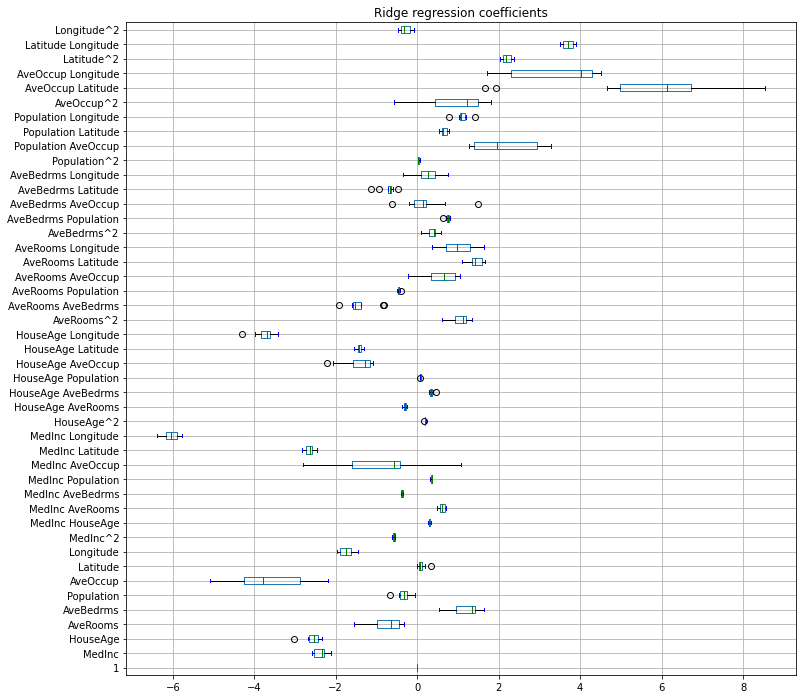

In [35]:
weights_ridge_df = pd.DataFrame(coefs, columns=feature_names)

color = {'whiskers': 'black', 'medians': 'green', 'caps': 'blue'}
weights_ridge_df.plot.box(color=color, vert=False, figsize=(12, 12))

plt.title('Ridge regression coefficients')
plt.grid()
plt.show()

### **Comparing Performance on test set**

#### 1. Baseline Model

In [36]:
baseline_model_median = DummyRegressor(strategy='median')
baseline_model_median.fit(train_features, train_labels)

mean_absolute_percentage_error(test_labels, baseline_model_median.predict(test_features))

0.5348927548151625

#### 2. Linear Regression with normal equation

In [37]:
mean_absolute_percentage_error(test_labels ,lin_reg_cv_results['estimator'][0].predict(test_features))

0.32120472175482895

#### 3. SGD regression with randomsearchCV

In [38]:
mean_absolute_percentage_error(test_labels ,poly_sgd_random_search_cv.best_estimator_.predict(test_features))

0.31523619087395877

#### 4. Polynomial Regression

In [39]:
poly_reg_pipeline.fit(com_train_features ,com_train_labels)

mean_absolute_percentage_error(test_labels ,poly_reg_pipeline.predict(test_features))

0.28199759082657094

#### 5. Lasso Regression

In [40]:
mean_absolute_percentage_error(test_labels ,lasso_grid_search.best_estimator_.predict(test_features))

0.280749692638101

#### 6. Ridge Regression

In [41]:
mean_absolute_percentage_error(test_labels ,ridge_grid_search.best_estimator_.predict(test_features))

0.2711033645132435